In [2]:
pip install ta

Note: you may need to restart the kernel to use updated packages.


In [3]:
# 1. Import Libraries
import numpy as np
import pandas as pd
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 2. Import Data
df = pd.read_csv('/kaggle/input/ril-and-hdfc-dataset/reliance_stock_2014_2024.csv')  # Update with your dataset path
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]  # Selecting relevant columns
df.dropna(inplace=True)  # Drop any rows with missing values

# 3. Feature Engineering
df['MA_10'] = df['Close'].rolling(10).mean()
df['EMA_20'] = df['Close'].ewm(span=20).mean()
df['RSI'] = ta.momentum.RSIIndicator(df['Close']).rsi()
df['MACD'] = ta.trend.MACD(df['Close']).macd()
df['Price_Change'] = df['Close'].pct_change()
df.dropna(inplace=True)  # Drop any rows with NaN values after feature engineering

# 4. Scaling the Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

2025-04-15 11:41:33.023106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744717293.268974      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744717293.334715      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


In [28]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# 5. Dataset Creation Function
def create_dataset(data, window_size=30):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i, 3])  # Predicting 'Close' (3rd column)
    return np.array(X), np.array(y)

# 6. Create Multi-Window Datasets
def create_multi_window_datasets(data, window_sizes):
    X_all = []
    for window in window_sizes:
        X, _ = create_dataset(data, window_size=window)
        X_all.append(X)
    return X_all

# 7. Prepare Data for 1-day, 3-day, 5-day windows
window_sizes = [1, 3, 5]
X_all = create_multi_window_datasets(scaled_data, window_sizes)

# Align target 'y' with the largest window
_, y = create_dataset(scaled_data, window_size=max(window_sizes))
X_all = [X[-len(y):] for X in X_all]  # Trim Xs to match y size

# 8. Train-Test Split
train_size = int(len(y) * 0.95)
X_train_all = [X[:train_size] for X in X_all]
X_test_all = [X[train_size:] for X in X_all]
y_train, y_test = y[:train_size], y[train_size:]

# Unpack
X_1_train, X_3_train, X_5_train = X_train_all
X_1_test, X_3_test, X_5_test = X_test_all

# 9. Define Multi-Input CNN-LSTM Model
def build_multi_input_model(input_shapes):
    inputs = []
    branches = []

    for shape in input_shapes:
        inp = Input(shape=shape)
        kernel_size = 1 if shape[0] == 1 else 2  # Use kernel size of 1 for very short sequences
        x = Conv1D(64, kernel_size=kernel_size, activation='relu')(inp)
        x = MaxPooling1D(2)(x)
        x = LSTM(64, return_sequences=True)(x)
        x = Dropout(0.3)(x)
        x = LSTM(32)(x)
        inputs.append(inp)
        branches.append(x)

    merged = Concatenate()(branches)
    x = Dense(64, activation='relu')(merged)
    x = Dropout(0.3)(x)
    output = Dense(1)(x)

    model = Model(inputs=inputs, outputs=output)
    return model

model = build_multi_input_model([
    (X_1_train.shape[1], X_1_train.shape[2]),
    (X_3_train.shape[1], X_3_train.shape[2]),
    (X_5_train.shape[1], X_5_train.shape[2])
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

# 10. Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# 11. Train Model
history = model.fit(
    [X_1_train, X_3_train, X_5_train],
    y_train,
    validation_data=([X_1_test, X_3_test, X_5_test], y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# 12. Predict & Inverse Transform
predicted_scaled = model.predict([X_1_test, X_3_test, X_5_test])

# Ensure correct dimensions for inverse transformation
dummy_pred = np.zeros((len(predicted_scaled), scaled_data.shape[1]))  # Initialize with the same number of columns
dummy_pred[:, 3] = predicted_scaled.flatten()  # Only update the 'Close' column
predicted = scaler.inverse_transform(dummy_pred)[:, 3]  # Inverse transform on predicted values

dummy_true = np.zeros((len(y_test), scaled_data.shape[1]))  # Initialize with the same number of columns
dummy_true[:, 3] = y_test  # Only update the 'Close' column
true = scaler.inverse_transform(dummy_true)[:, 3]  # Inverse transform on actual values

# 13. Return Predictions and True Values
return predicted, true


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21            │ (None, 3, 10)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_22            │ (None, 5, 10)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_20            │ (None, 1, 10)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_24 (Conv1D)        │ (None, 2, 64)          │          1,344 │ input_layer_21[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_25 (Conv1D)        │ (None, 4, 64)          │          1,344 │ input_layer_22[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_23 (Conv1D)        │ (None, 1, 64)          │            704 │ input_layer_20[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_23          │ (None, 1, 64)          │              0 │ conv1d_24[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_24          │ (None, 2, 64)          │              0 │ conv1d_25[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_37 (LSTM)            │ (None, 1, 64)          │         33,024 │ conv1d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_39 (LSTM)            │ (None, 1, 64)          │         33,024 │ max_pooling1d_23[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_41 (LSTM)            │ (None, 2, 64)          │         33,024 │ max_pooling1d_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_29 (Dropout)      │ (None, 1, 64)          │              0 │ lstm_37[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_30 (Dropout)      │ (None, 1, 64)          │              0 │ lstm_39[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_31 (Dropout)      │ (None, 2, 64)          │              0 │ lstm_41[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_38 (LSTM)            │ (None, 32)             │         12,416 │ dropout_29[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_40 (LSTM)            │ (None, 32)             │         12,416 │ dropout_30[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_42 (LSTM)            │ (None, 32)             │         12,416 │ dropout_31[0][0]       │
├──────────────────────

 Total params: 145,985 (570.25 KB)

 Trainable params: 145,985 (570.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0616 - val_loss: 0.0069 - learning_rate: 0.0010
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0042 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0035 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0033 - val_loss: 3.2474e-04 - learning_rate: 0.0010
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0031 - val_loss: 3.6385e-04 - learning_rate: 0.0010
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0034 - val_loss: 4.7897e-04 - learning_rate: 0.0010
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0030 - val_loss: 5.9311e-04 - learning_rate: 0.0010
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0030 - val_loss: 0.0014 - learning_rate: 

SyntaxError: 'return' outside function (4185423399.py, line 106)

In [30]:
# 12. Predict & Inverse Transform
predicted_scaled = model.predict([X_1_test, X_3_test, X_5_test])

# Ensure correct dimensions for inverse transformation
dummy_pred = np.zeros((len(predicted_scaled), scaled_data.shape[1]))  # Initialize with the same number of columns
dummy_pred[:, 3] = predicted_scaled.flatten()  # Only update the 'Close' column
predicted = scaler.inverse_transform(dummy_pred)[:, 3]  # Inverse transform on predicted values

dummy_true = np.zeros((len(y_test), scaled_data.shape[1]))  # Initialize with the same number of columns
dummy_true[:, 3] = y_test  # Only update the 'Close' column
true = scaler.inverse_transform(dummy_true)[:, 3]  # Inverse transform on actual values


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 12. Predict & Inverse Transform
predicted_scaled = model.predict([X_1_test, X_3_test, X_5_test])

# Invert scaled predictions and actuals to original Close prices
dummy_pred = np.zeros((len(predicted_scaled), scaled_data.shape[1]))
dummy_pred[:, 3] = predicted_scaled.flatten()
predicted_rescaled = scaler.inverse_transform(dummy_pred)[:, 3]

dummy_true = np.zeros((len(y_test), scaled_data.shape[1]))
dummy_true[:, 3] = y_test
true_rescaled = scaler.inverse_transform(dummy_true)[:, 3]

# Convert to directional movement: 1 for up, 0 for down/same
y_test_class = np.where(np.diff(true_rescaled, prepend=true_rescaled[0]) > 0, 1, 0)
y_pred_class = np.where(np.diff(predicted_rescaled, prepend=predicted_rescaled[0]) > 0, 1, 0)

# Metrics calculation
mae = mean_absolute_error(true_rescaled, predicted_rescaled)
rmse = np.sqrt(mean_squared_error(true_rescaled, predicted_rescaled))
r2 = r2_score(true_rescaled, predicted_rescaled)
mape = np.mean(np.abs((true_rescaled - predicted_rescaled) / true_rescaled)) * 100

# Print Results
print(f"✅ MAE: ₹{mae:.2f}")
print(f"✅ RMSE: ₹{rmse:.2f}")
print(f"✅ R² Score: {r2:.4f}")
print(f"✅ MAPE: {mape:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
✅ MAE: ₹17.79
✅ RMSE: ₹23.02
✅ R² Score: 0.9567
✅ MAPE: 1.27%


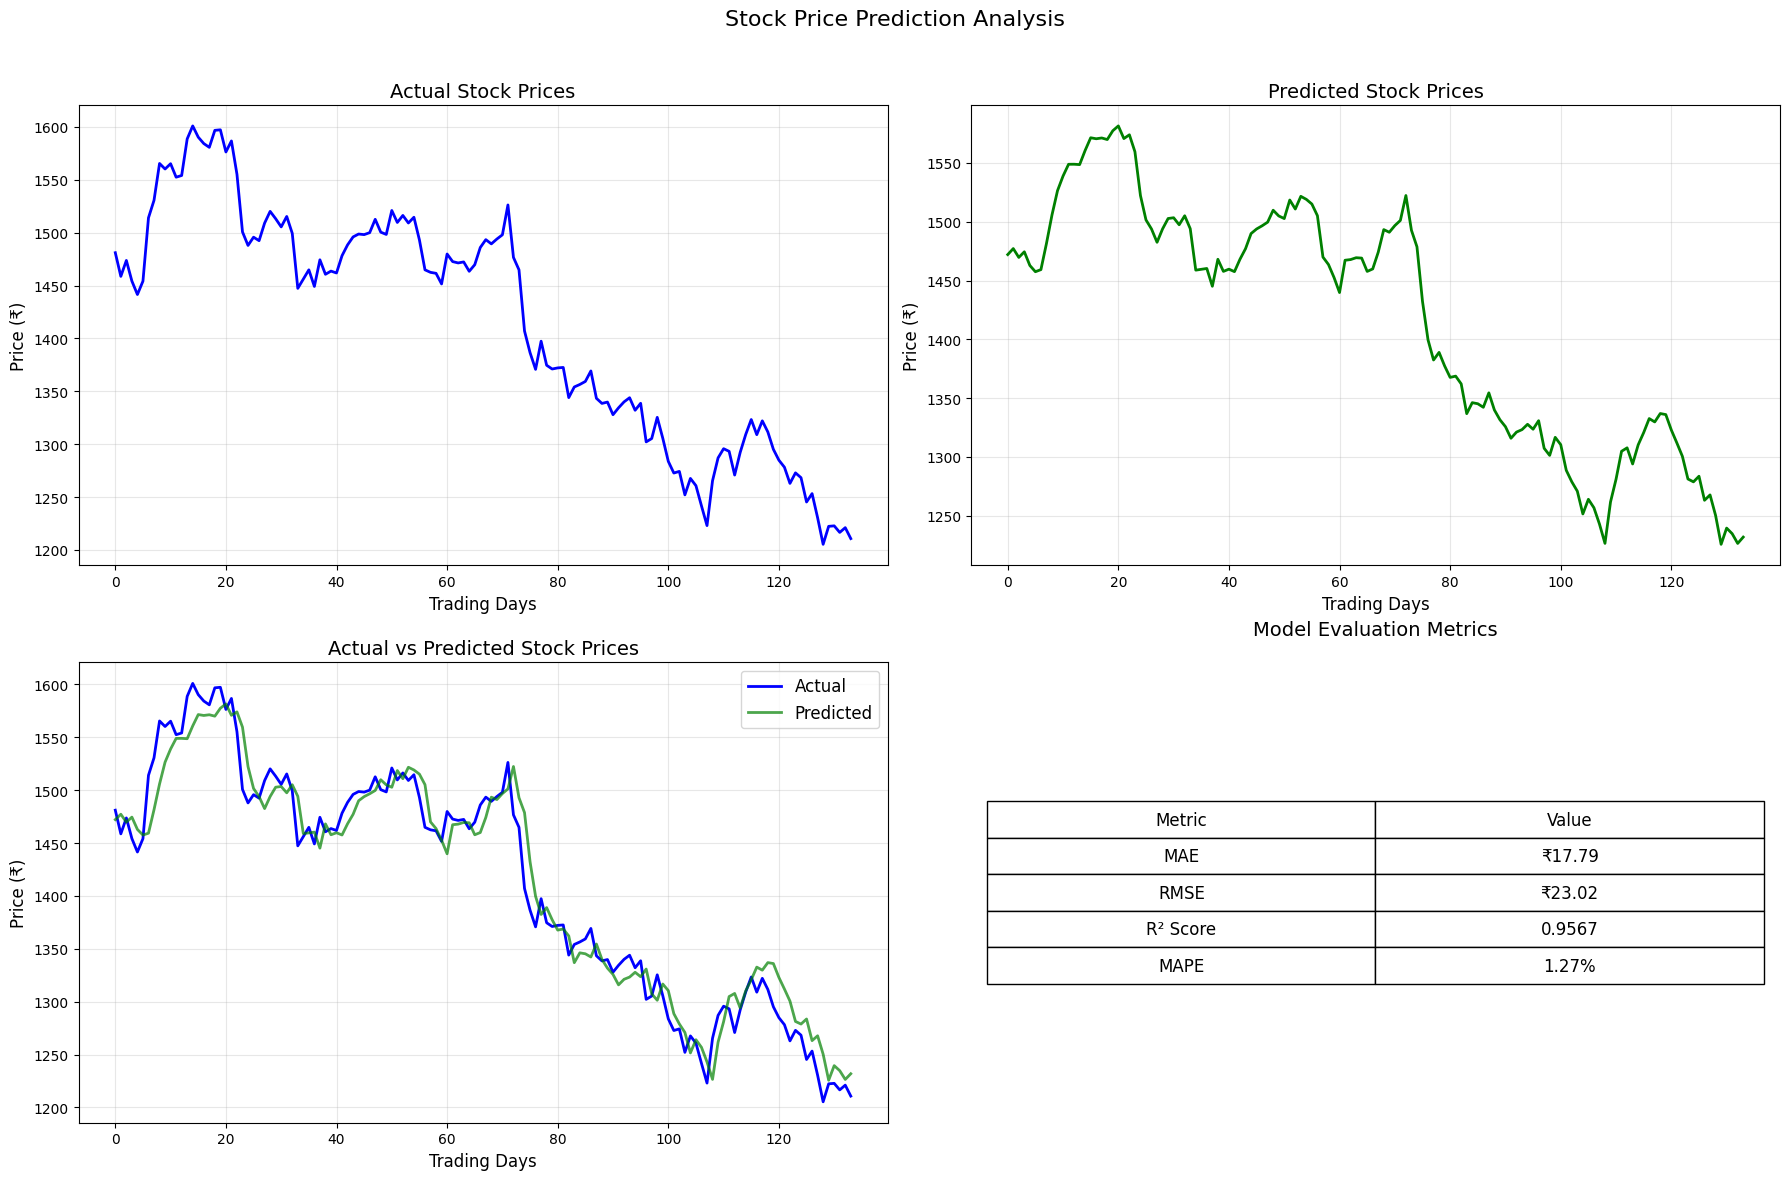

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create figure for visualization
plt.figure(figsize=(18, 12))

# 1. Graph of Actual Values
plt.subplot(2, 2, 1)
plt.plot(true_rescaled, color='blue', linewidth=2)
plt.title('Actual Stock Prices', fontsize=14)
plt.xlabel('Trading Days', fontsize=12)
plt.ylabel('Price (₹)', fontsize=12)
plt.grid(True, alpha=0.3)

# 2. Graph of Predicted Values
plt.subplot(2, 2, 2)
plt.plot(predicted_rescaled, color='green', linewidth=2)
plt.title('Predicted Stock Prices', fontsize=14)
plt.xlabel('Trading Days', fontsize=12)
plt.ylabel('Price (₹)', fontsize=12)
plt.grid(True, alpha=0.3)

# 3. Graph of Actual vs Predicted Values
plt.subplot(2, 2, 3)
plt.plot(true_rescaled, color='blue', label='Actual', linewidth=2)
plt.plot(predicted_rescaled, color='green', label='Predicted', linewidth=2, alpha=0.7)
plt.title('Actual vs Predicted Stock Prices', fontsize=14)
plt.xlabel('Trading Days', fontsize=12)
plt.ylabel('Price (₹)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# 4. Table of Evaluation Metrics
plt.subplot(2, 2, 4)
plt.axis('off')

# Metrics for regression
metrics = [
    ['Metric', 'Value'],
    ['MAE', f'₹{mae:.2f}'],
    ['RMSE', f'₹{rmse:.2f}'],
    ['R² Score', f'{r2:.4f}'],
    ['MAPE', f'{mape:.2f}%'],
]

# Calculate additional directional metrics
accuracy_dir = accuracy_score(y_test_class, y_pred_class) * 100
precision = precision_score(y_test_class, y_pred_class, zero_division=0) * 100
recall = recall_score(y_test_class, y_pred_class, zero_division=0) * 100
f1 = f1_score(y_test_class, y_pred_class, zero_division=0) * 100

# Add directional metrics to table

# Create the table
table = plt.table(
    cellText=metrics,
    cellLoc='center',
    loc='center',
    colWidths=[0.4, 0.4]
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2)
plt.title('Model Evaluation Metrics', fontsize=14, pad=20)

# Adjust layout and display the plot
plt.tight_layout()
plt.suptitle('Stock Price Prediction Analysis', fontsize=16, y=0.98)
plt.subplots_adjust(top=0.9)

# Save figure as a PNG file
plt.savefig('stock_prediction_results.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()